# Example: Measuring GFP positive neuron proportion

This notebook demonstrates how we can classify nuclei as either positive or negative for two differet markers, and then calculate the overlap between these.

Specifically, this pipeline was used to calculate the proportion of neurons that expressed the gfp fusion protein indicating successfull knockout of the TDG gene.

## Import dependencies

The following libraries are used for the data processing, clustering, statistical calculations and visualization

In [2]:
import pandas as pd
import napari
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import MultiComparison
from sklearn.cluster import KMeans
import numpy as np
import sys
sys.path.insert(1, '/Users/jonas/Documents/nucleus_analysis/nuclei')
from utils import readImage
pd.set_option('display.width', 2000)
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

## Load .csv file

The .csv file is loaded, and a Pandas dataframe is created from it.
We inspect the structure of the dataframe by printing it.

In [9]:
nucleus_df = pd.read_csv('csv/nuclei_liv_test.csv')
print(nucleus_df)

       Condition                          ImageName  Label    Area                                           Centroid   CellType  Ch1Intensity  Ch2Intensity  Ch3Intensity
0             DG   170123_A1_363_NeuN-GFP_S2_DG.czi      1  2090.0  (20.383732057416267, 556.8325358851674, 1692.4...  Undefined     28.441627    197.297129     18.239713
1             DG   170123_A1_363_NeuN-GFP_S2_DG.czi      2  3358.0  (20.22900536033353, 316.22453841572366, 548.24...  Undefined     27.680465     66.195057     34.830554
2             DG   170123_A1_363_NeuN-GFP_S2_DG.czi      3  2013.0  (16.98708395429707, 1252.2762046696473, 588.39...  Undefined     28.562842    226.718828     16.508197
3             DG   170123_A1_363_NeuN-GFP_S2_DG.czi      4  2474.0  (15.221099434114794, 2457.227162489895, 407.10...  Undefined     30.666128    228.996766      8.021827
4             DG   170123_A1_363_NeuN-GFP_S2_DG.czi      5  2160.0  (17.185185185185187, 1479.5439814814815, 1265....  Undefined     39.560648   

## Classifying Neurons

Firstly, we wish to identify the neurons of the images. This is done by clustering based on NeuN fluorescence.

A k-means clustering is conducted. n_clusters indicates the number of clusters. In this case, this is two: Neurons and non-neurons.



In [27]:
#channel_key inticates which column we should cluster by.
channel_key = 'Ch1Intensity'
nucleus_df['Cluster_Label'] = np.nan
num_clusters = 2

for name in nucleus_df['ImageName'].unique():
    df = nucleus_df[nucleus_df['ImageName'] == name]
    intensity_values = df[channel_key].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(intensity_values)
    sorted_clusters = np.argsort(kmeans.cluster_centers_.flatten())
    cluster_labels = sorted_clusters[clusters] 
    nucleus_df.loc[df.index, 'Cluster_Label'] = cluster_labels

nucleus_df.loc[nucleus_df['Cluster_Label'] == 1.0, 'CellType'] = 'Neuron'
nucleus_df.drop(columns=['Cluster_Label'], inplace=True)
print(nucleus_df.head())

  Condition                         ImageName  Label    Area                                           Centroid   CellType  Ch1Intensity  Ch2Intensity  Ch3Intensity GFP_positive
0        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      1  2090.0  (20.383732057416267, 556.8325358851674, 1692.4...  Undefined     28.441627    197.297129     18.239713          NaN
1        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      2  3358.0  (20.22900536033353, 316.22453841572366, 548.24...  Undefined     27.680465     66.195057     34.830554         True
2        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      3  2013.0  (16.98708395429707, 1252.2762046696473, 588.39...  Undefined     28.562842    226.718828     16.508197          NaN
3        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      4  2474.0  (15.221099434114794, 2457.227162489895, 407.10...  Undefined     30.666128    228.996766      8.021827          NaN
4        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      5  2160.0  (17.185185185185187, 1479.5439814814815, 1265...

### Verify classification

In order to inspect whether or not our classification was successfull we may both:
- Display positive nuclei in the image

In [18]:
img_name = '170123_A1_363_NeuN-GFP_S1_MEC.czi' # 'Enter name of image as it appears in nucleus_df'
img_path = 'D:/Users\Jonas/nuclei\imagesAndMasks\liv\mec/170123_A1_363_NeuN-GFP_S1_MEC.czi' # 'Path to same image'

neuron_df = nucleus_df[nucleus_df['CellType'] == 'Neuron']
img_df = neuron_df[neuron_df['ImageName'] == img_name]

centroids = img_df['Centroid'].apply(eval)

# Convert centroids to a NumPy array
centroids_array = np.array(centroids.tolist())  # Transpose the array to get the desired shape


from skimage import io
import napari
img= readImage(img_path)

viewer = napari.view_image(img, scale =([0.9278, 0.3459, 0.3459]), channel_axis=3 )
viewer.add_points(centroids_array, size=10, symbol='cross', edge_color='blue', face_color='blue', name='Nuclei Centroids', scale=([0.9278, 0.3459, 0.3459]))
napari.run()

- Combination of violinplot and boxplot

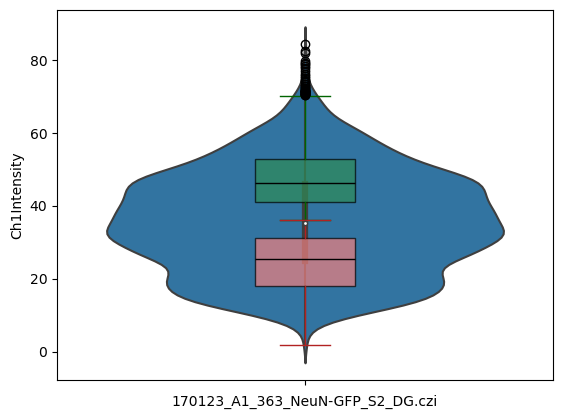

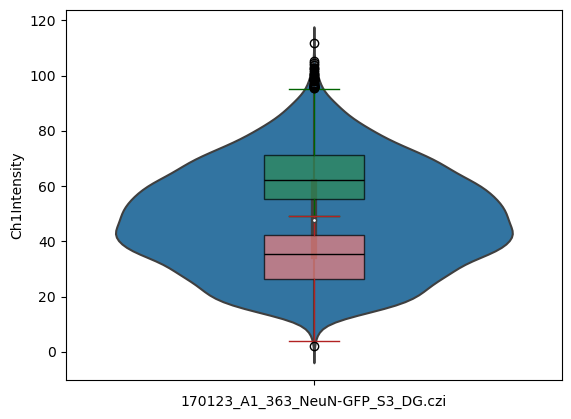

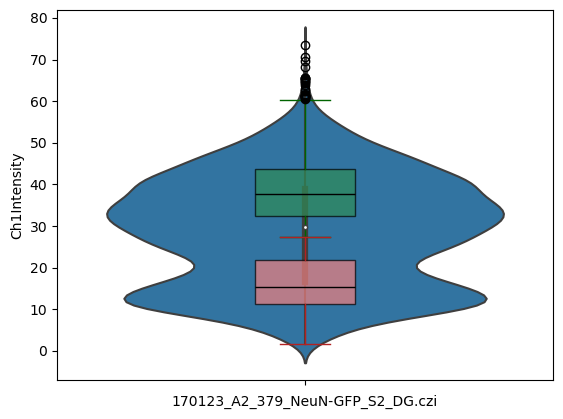

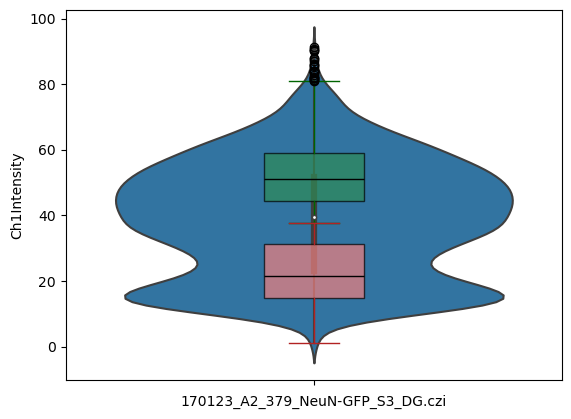

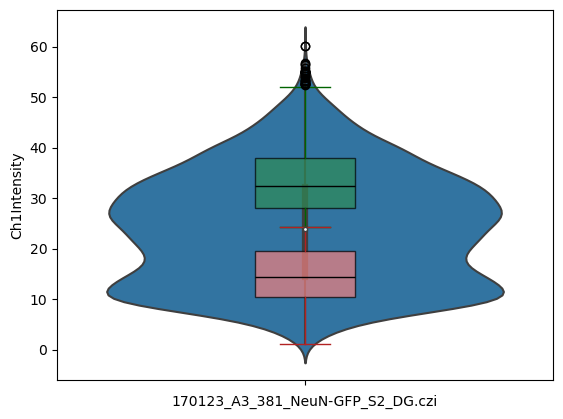

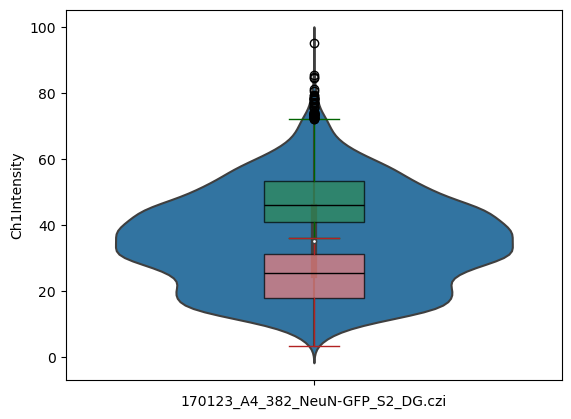

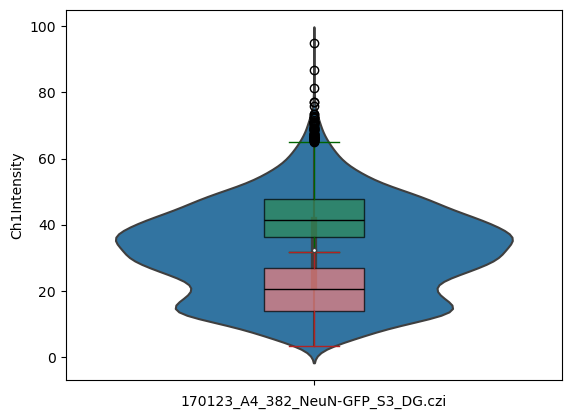

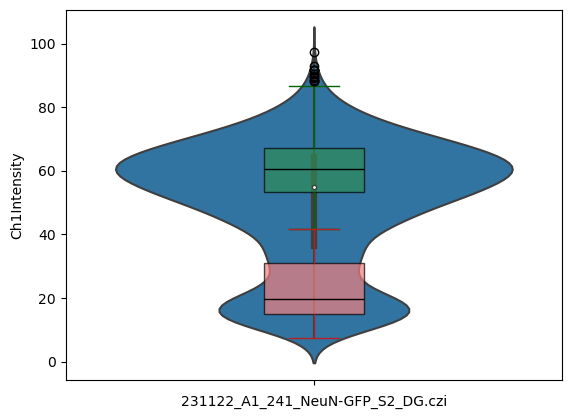

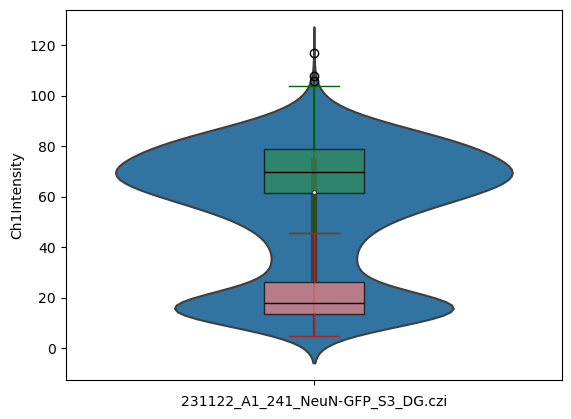

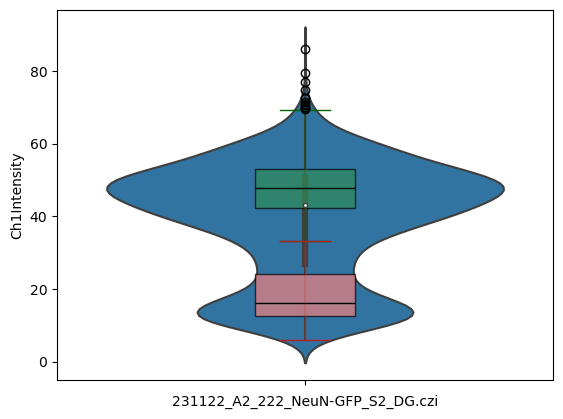

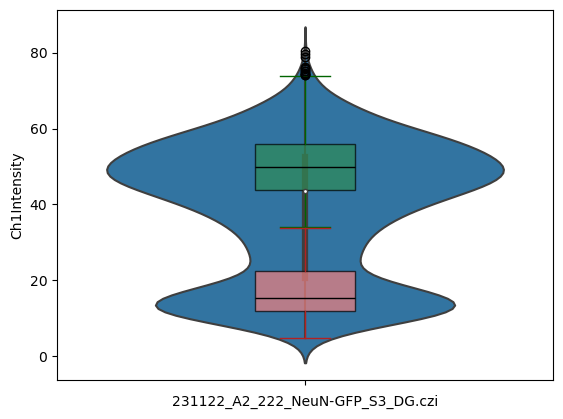

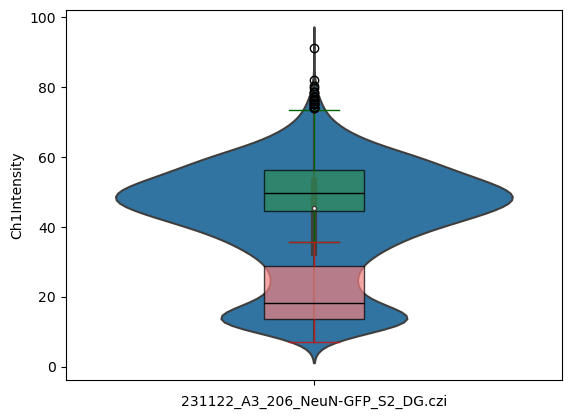

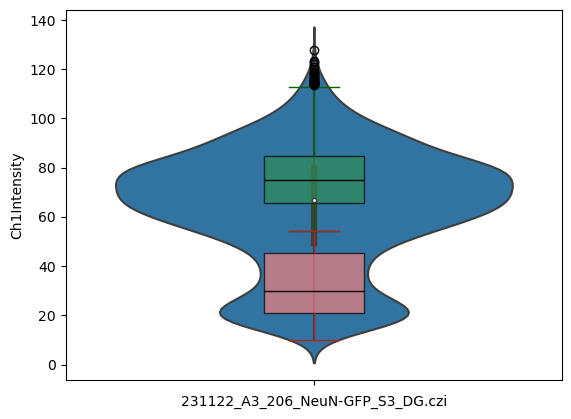

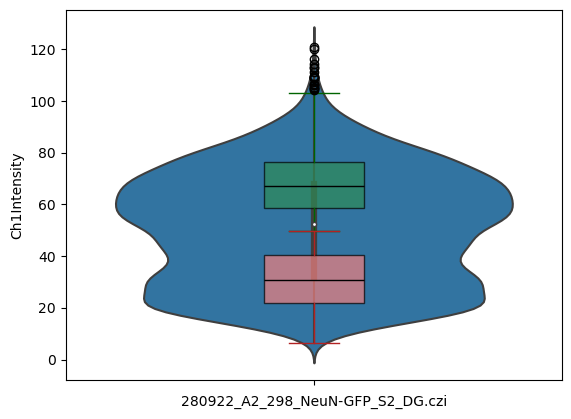

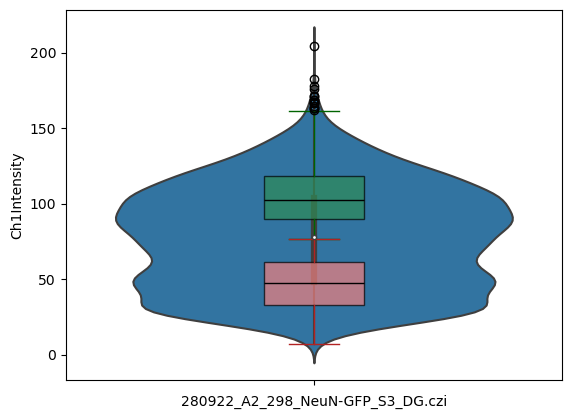

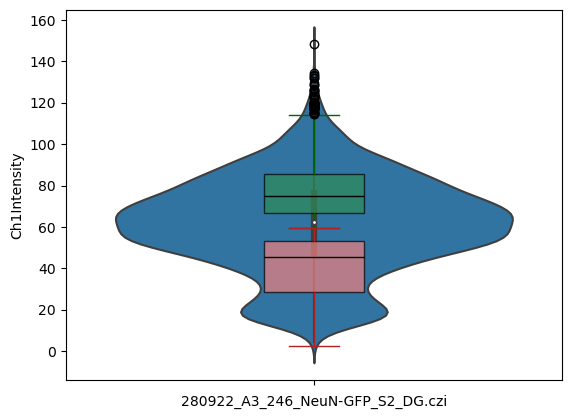

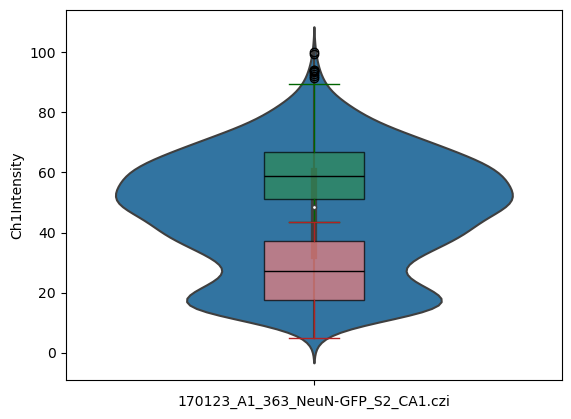

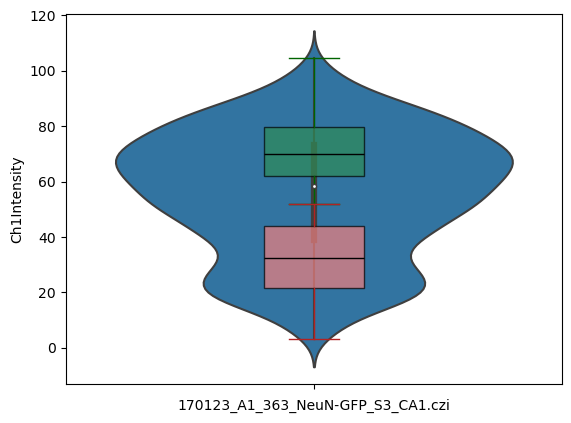

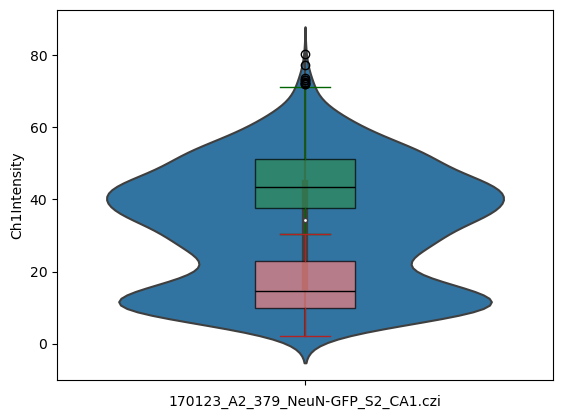

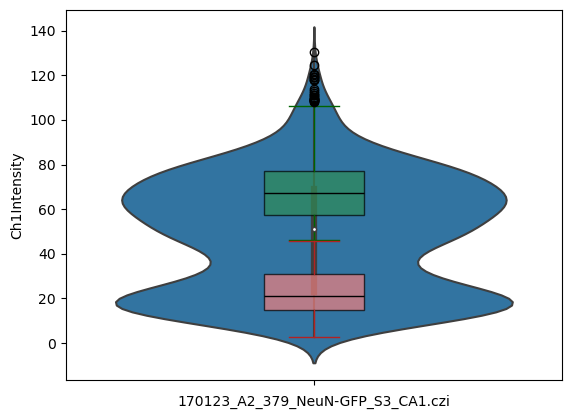

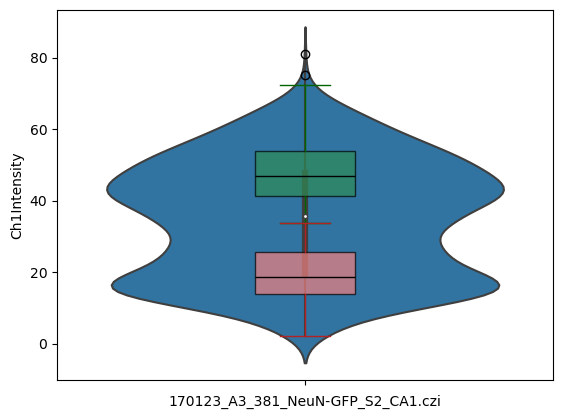

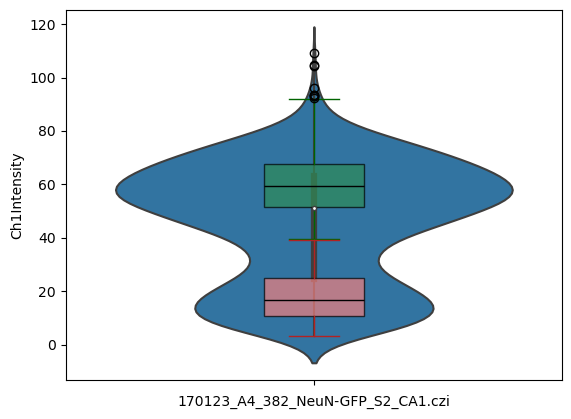

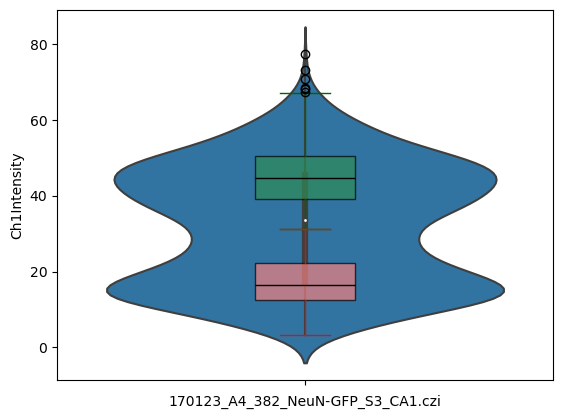

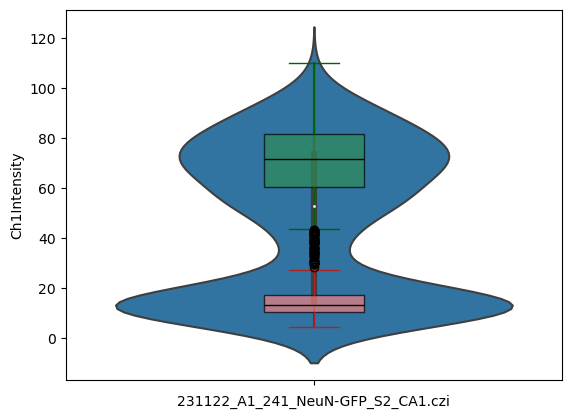

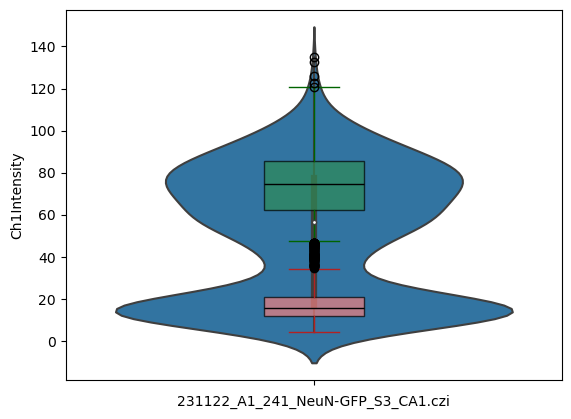

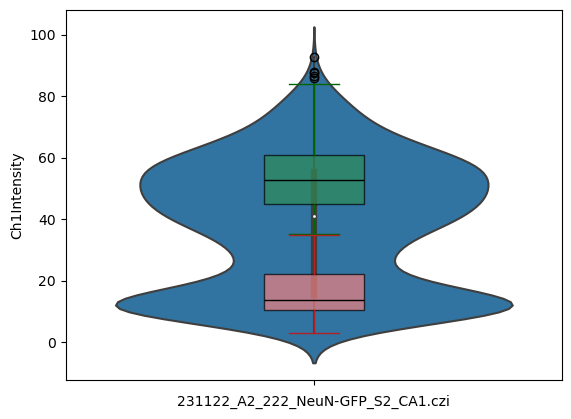

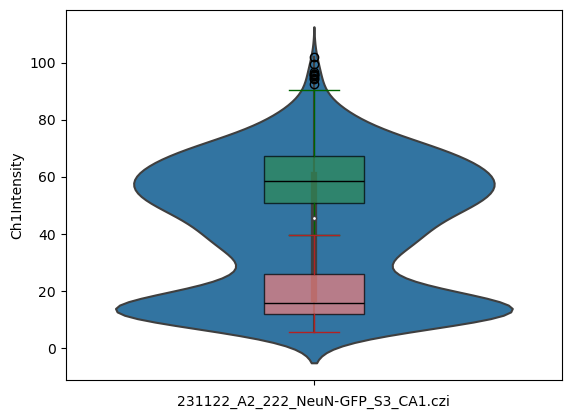

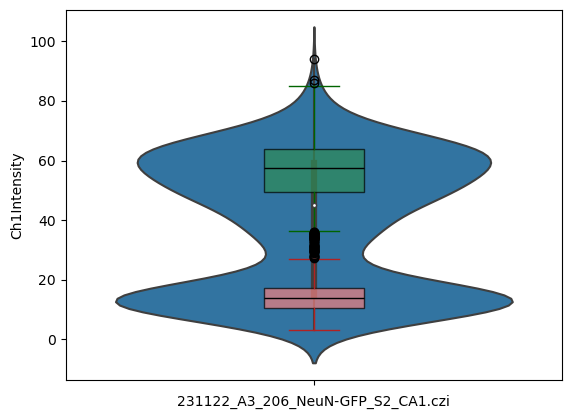

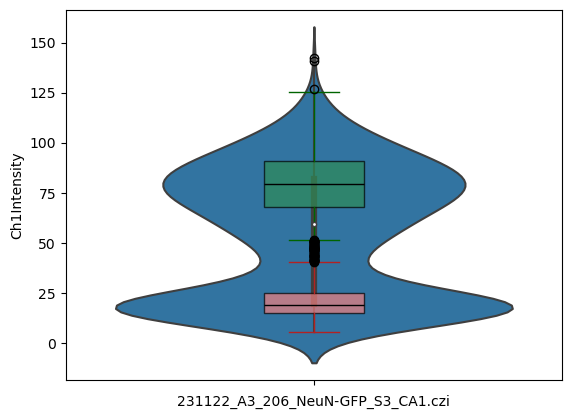

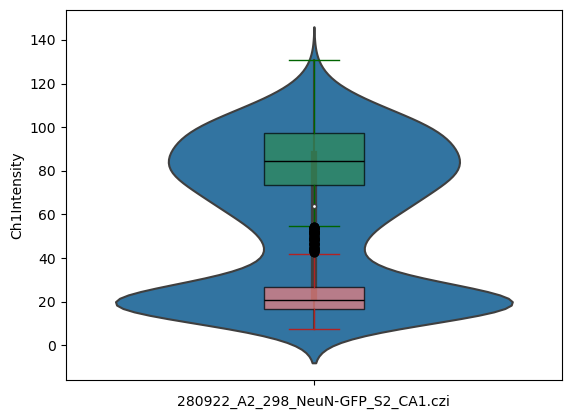

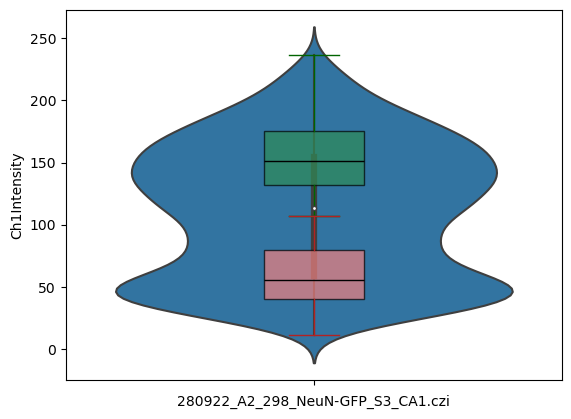

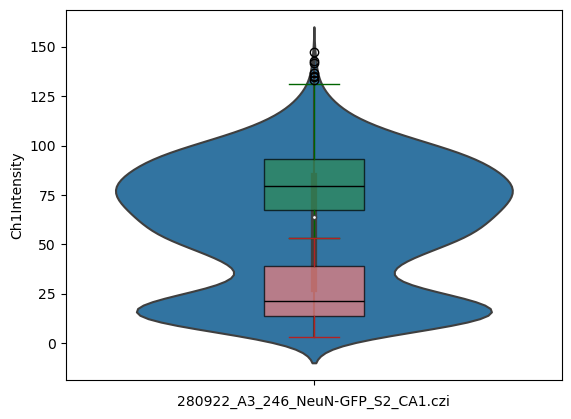

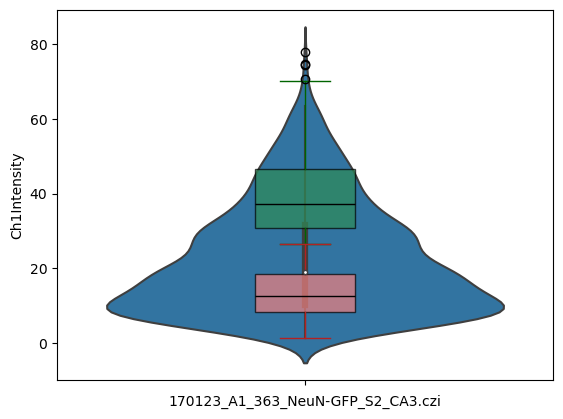

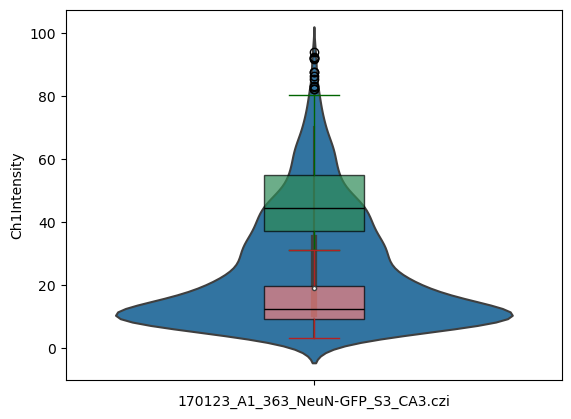

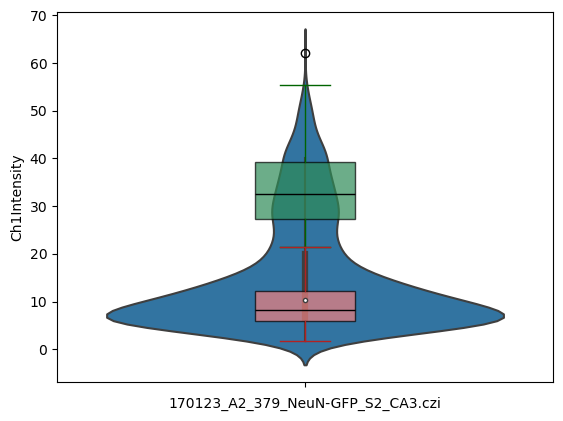

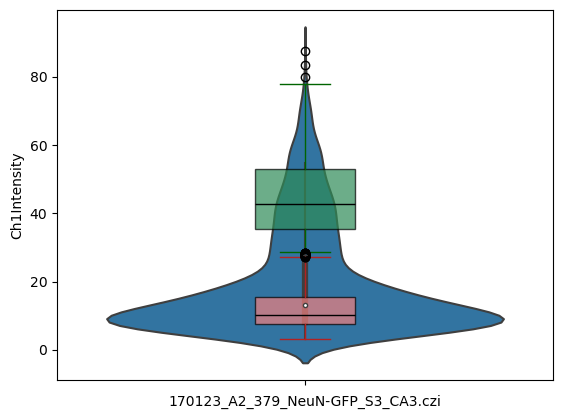

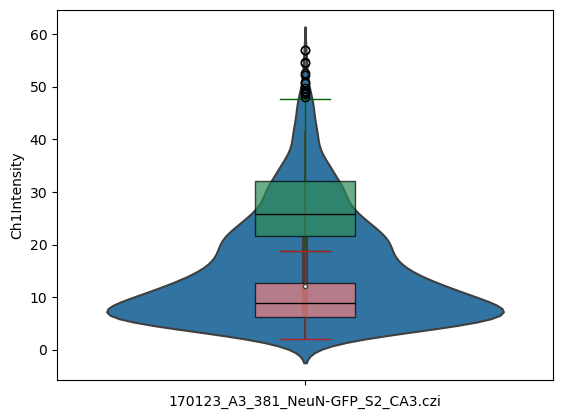

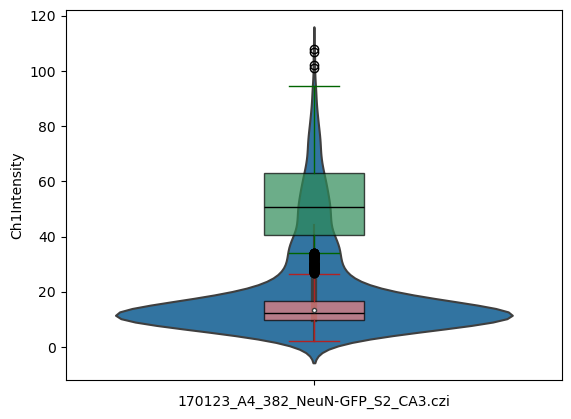

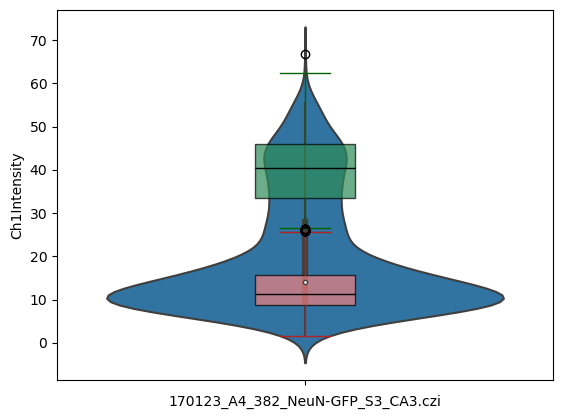

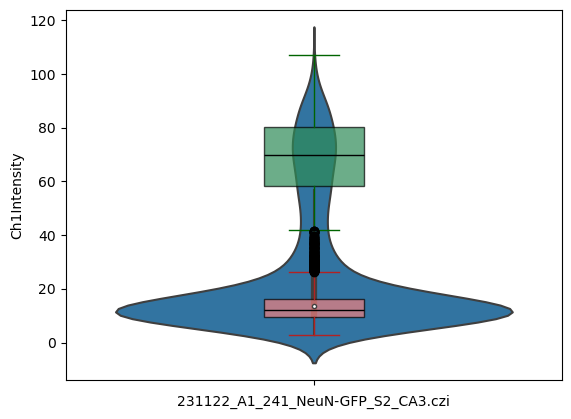

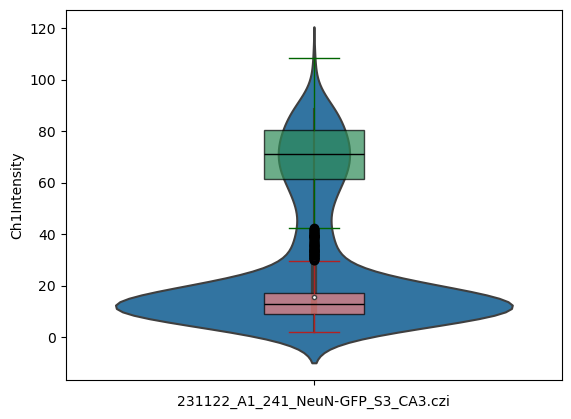

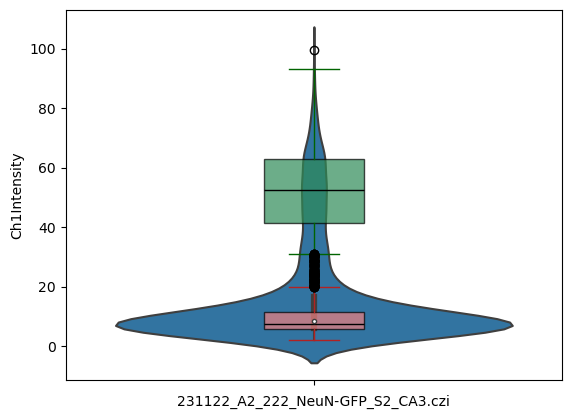

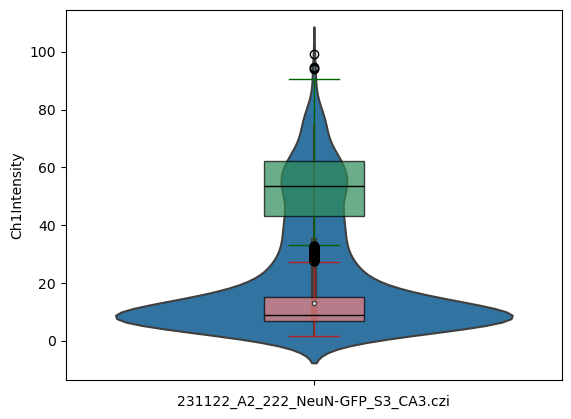

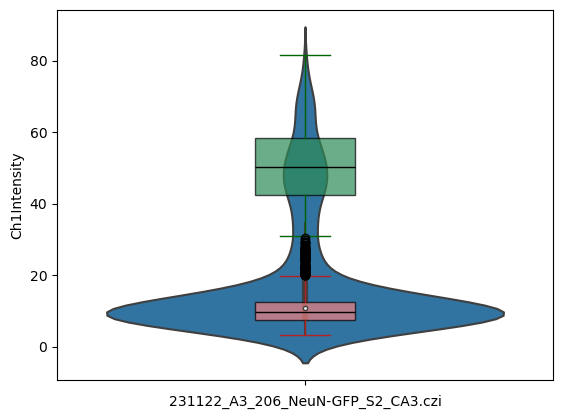

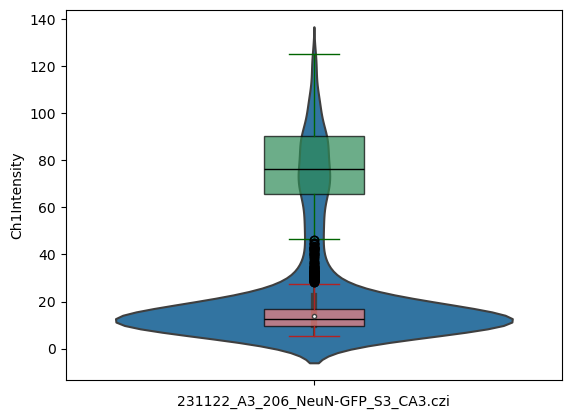

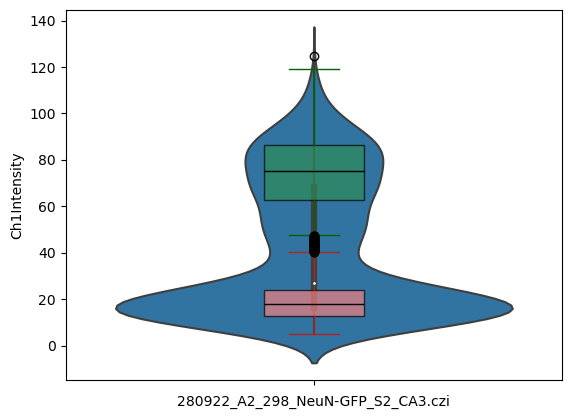

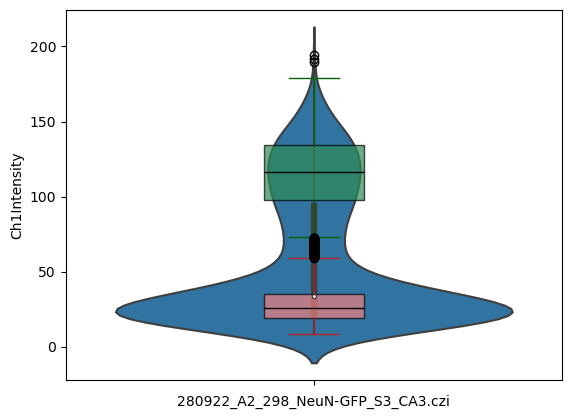

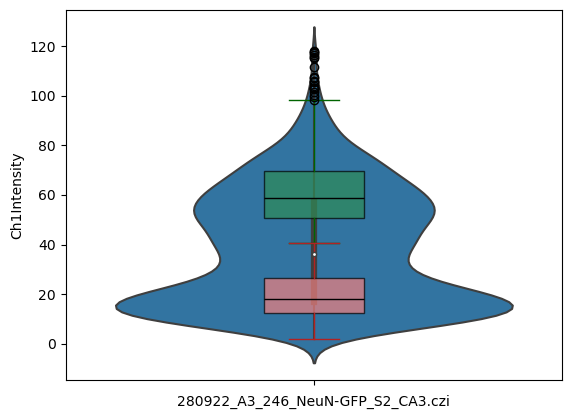

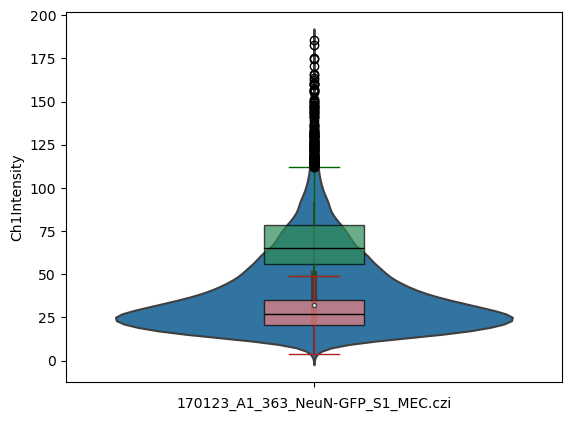

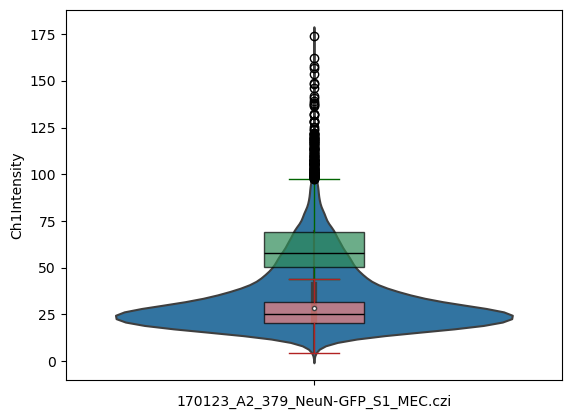

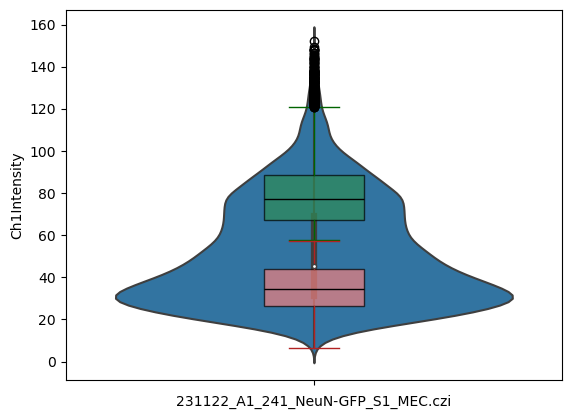

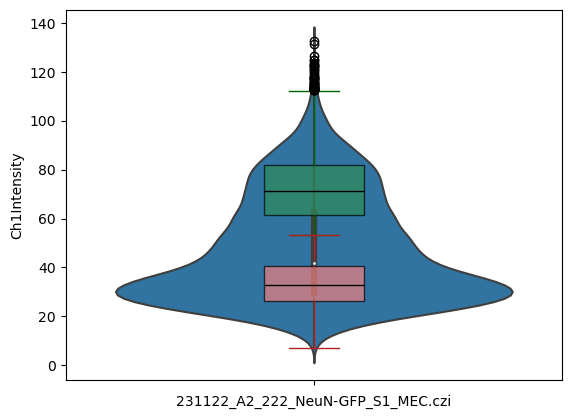

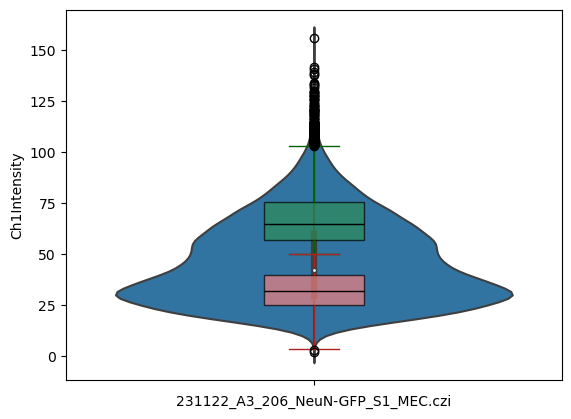

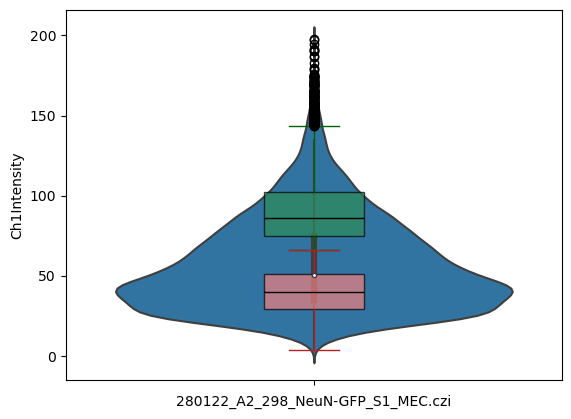

In [32]:
channel_key = 'Ch1Intensity'

for name in nucleus_df['ImageName'].unique():
    neuron_intensities = []
    undefined_intensities = []
    df = nucleus_df[nucleus_df['ImageName'] == name]
    neuron_intensities.extend(df[df['CellType'] == 'Neuron'][channel_key].tolist())
    # Filter 'Ch1Intensity' values where 'CellType' == 'Undefined'
    undefined_intensities.extend(df[df['CellType'] == 'Undefined'][channel_key].tolist())
    shared_values = set(neuron_intensities) & set(undefined_intensities)
    if shared_values:
        print(f"Shared values found: {shared_values}")
    fig, ax = plt.subplots()
    sns.violinplot(data=df, x='ImageName', y=channel_key, zorder=1, ax=ax)
    ax.boxplot(neuron_intensities, positions=[0], widths=0.2, patch_artist=True,
            boxprops=dict(facecolor="seagreen", zorder=2, alpha=.7),
            medianprops=dict(color="black"),
            whiskerprops=dict(color="darkgreen"),
            capprops=dict(color="darkgreen"))

    ax.boxplot(undefined_intensities, positions=[0], widths=0.2, patch_artist=True,
            boxprops=dict(facecolor="lightcoral", zorder=2, alpha=.7),
            medianprops=dict(color="black"),
            whiskerprops=dict(color="firebrick"),
            capprops=dict(color="firebrick"))
    plt.xlabel(name)
    plt.xticks([0],"")
    plt.show()

## Classify GFP positive 

In [11]:
channel_key = 'Ch3Intensity'
nucleus_df['Cluster_Label'] = np.nan
nucleus_df['GFP_positive'] = np.nan


for name in nucleus_df['ImageName'].unique():
    df = nucleus_df[nucleus_df['ImageName'] == name]
    intensity_values = df[channel_key].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(intensity_values)
    sorted_clusters = np.argsort(kmeans.cluster_centers_.flatten())
    cluster_labels = sorted_clusters[clusters]  # Map cluster indices to sorted clusters
    nucleus_df.loc[df.index, 'Cluster_Label'] = cluster_labels

nucleus_df.loc[nucleus_df['Cluster_Label'] == 1.0, 'GFP_positive'] = True
nucleus_df.drop(columns=['Cluster_Label'], inplace=True)
print(nucleus_df.head())

  Condition                         ImageName  Label    Area                                           Centroid   CellType  Ch1Intensity  Ch2Intensity  Ch3Intensity GFP_positive
0        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      1  2090.0  (20.383732057416267, 556.8325358851674, 1692.4...  Undefined     28.441627    197.297129     18.239713          NaN
1        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      2  3358.0  (20.22900536033353, 316.22453841572366, 548.24...  Undefined     27.680465     66.195057     34.830554         True
2        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      3  2013.0  (16.98708395429707, 1252.2762046696473, 588.39...  Undefined     28.562842    226.718828     16.508197          NaN
3        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      4  2474.0  (15.221099434114794, 2457.227162489895, 407.10...  Undefined     30.666128    228.996766      8.021827          NaN
4        DG  170123_A1_363_NeuN-GFP_S2_DG.czi      5  2160.0  (17.185185185185187, 1479.5439814814815, 1265...

C:\Users\jonasvg\AppData\Local\Temp\ipykernel_7064\1553083108.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  nucleus_df.loc[nucleus_df['Cluster_Label'] == 1.0, 'GFP_positive'] = True


In [12]:
result = nucleus_df.groupby('ImageName').agg(
    Condition=('Condition', 'first'),
    TotalNuclei=('Label', 'count'),
    NeuronNuclei=('CellType', lambda x: (x == 'Neuron').sum()),
     GFPPositiveNuclei=('GFP_positive', lambda x: x.sum()),
     NeuronAndGFPPositive=('GFP_positive', lambda x: ((x == True) & (nucleus_df['CellType'] == 'Neuron')).sum())
)
result['ProportionNeuronAndGFP'] = result['NeuronAndGFPPositive'] / result['NeuronNuclei']
print(result)

                                  Condition  TotalNuclei  NeuronNuclei  GFPPositiveNuclei  NeuronAndGFPPositive  ProportionNeuronAndGFP
ImageName                                                                                                                              
170123_A1_363_NeuN-GFP_S1_MEC.czi       MEC        19050          4993               3689                  2610                0.522732
170123_A1_363_NeuN-GFP_S2_CA1.czi       CA1         2029          1190               1265                  1078                0.905882
170123_A1_363_NeuN-GFP_S2_CA3.czi       CA3         1713           600                176                   172                0.286667
170123_A1_363_NeuN-GFP_S2_DG.czi         DG         6823          3294               2066                  1849                0.561324
170123_A1_363_NeuN-GFP_S3_CA1.czi       CA1         1961          1165               1201                  1086                0.932189
170123_A1_363_NeuN-GFP_S3_CA3.czi       CA3     

## Visualize results

c:\Users\jonasvg\AppData\Local\miniconda3\envs\image_analysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jonasvg\AppData\Local\miniconda3\envs\image_analysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


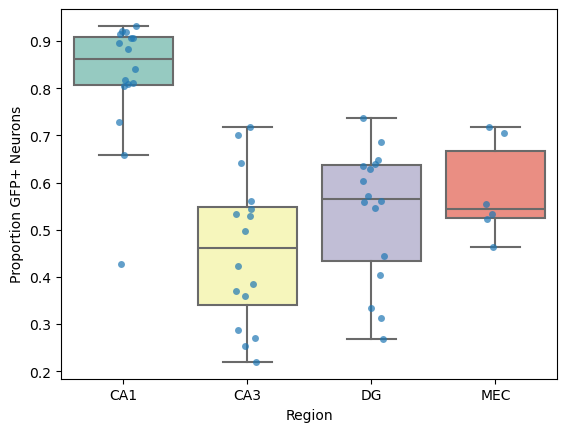

In [13]:
sns.boxplot(data=result, x='Condition', y='ProportionNeuronAndGFP', showfliers=False,order=['CA1','CA3','DG', 'MEC'], palette="Set3")
sns.stripplot(data=result, x='Condition', y='ProportionNeuronAndGFP', order=['CA1','CA3','DG', 'MEC'], alpha=0.7)
plt.xlabel("Region")
plt.ylabel("Proportion GFP+ Neurons")
#plt.savefig('gfpNeurons.pdf')
plt.show()